# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import umap.umap_ as umap
from sklearn.decomposition import PCA



from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import ast


import os
os.getcwd()

c:\Users\tinac\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'c:\\Users\\tinac\\OneDrive - 한양대학교\\2023\\KB\\3. DCX\\5. 1차_KMeans+ TF-IDF\\2차'

In [2]:
# 함수모음

def erase_double_blank(string):
    result = string
    while "  " in result:
        result = result.replace("  ", " ")
    while ",," in result:
        result = result.replace(",,", ",")
    while ", ," in result:
        result = result.replace(", ,", ",")
    result = result.replace("[, ", "[")
    result = result.replace(", ]", "]")
    return result

def visualize_silhouette_layer(data, num_cluster):
    clusters_range = range(2, int(num_cluster))
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, random_state=42, n_init=10)  # KMeans를 사용하도록 변경
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_ac = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    return result, pivot_ac

def visualize_silhouette(cluster_lists, X_features):     
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0, n_init=10)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

def visualize_inertia(cluster_lists, X_features):
    inertias = []
    for n_cluster in cluster_lists:
        k_means = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0, n_init=10)
        k_means.fit(X_features)
        inertias.append(k_means.inertia_)
        
    sns.lineplot(x=cluster_lists, y=inertias)        

In [3]:
df = pd.read_csv('tokendm_total_informative_mecab_nonf.csv')
num_clusters = 5  # 클러스터의 수를 설정

# Vector 사용하기

In [4]:
df["vector"] = df["vector"].apply(lambda x : str(x).replace("\n", " "))
df["vector"] = df["vector"].apply(lambda x : str(x).replace(" ", ", "))
df["vector"] = df["vector"].apply(lambda x : erase_double_blank(x))
df["vector"] = df["vector"].apply(lambda x : ast.literal_eval(x))

In [5]:
vector_array = np.array(df['vector'].tolist())

# K-means

In [6]:
# 실루엣 점수 보는 코드 
# 처음 돌릴때 사용!

# result, pivot_ac = visualize_silhouette_layer(vector_array,20)
# print(result)

# plt.plot(result.n_clusters, result.silhouette_score)

# visualize_silhouette([2, 3, 4, 5, 6, 7], vector_array)

# visualize_inertia([i for i in range(2, 20)], vector_array)

# K-means 예측하기

In [7]:
# KMeans 클러스터링을 수행
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(vector_array)

# 시각화하기

In [8]:
# UMAP 모델 생성
n_components = 3  # 3차원으로 축소
umap_model = umap.UMAP(n_components=n_components)
umap_data = umap_model.fit_transform(vector_array)

<Figure size 800x600 with 0 Axes>

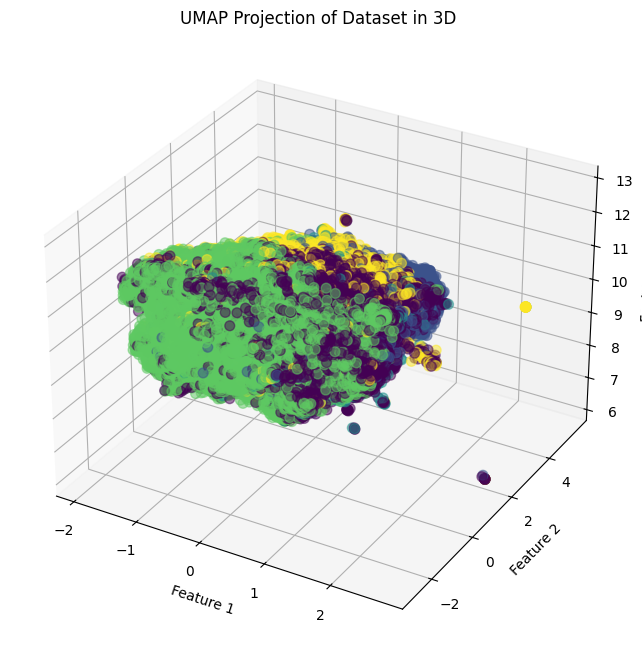

<Figure size 640x480 with 0 Axes>

In [10]:
# KMeans 클러스터링 결과를 시각화
plt.figure(figsize=(8, 6))

# 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_data[:, 0], umap_data[:, 1], umap_data[:, 2], c=kmeans_labels, cmap='viridis', s=50, alpha=0.5)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('UMAP Projection of Dataset in 3D')
plt.show()
plt.savefig(f"./{num_clusters}_UMAP_3d")

In [12]:
# 3차원으로 차원 축소, target 정보는 제외
pca = PCA(n_components = 3)
pca.fit(vector_array)
 
# pca transform 후 데이터프레임으로 자료형 변경
df_pca = pca.transform(vector_array)
df_pca = pd.DataFrame(df_pca, columns = ['component 0', 'component 1', 'component 2'])

df_pca

,component 0,component 1,component 2
0,-0.448874,0.350237,0.479670
1,1.391227,-0.129848,0.356307
2,1.367733,-0.290756,1.192649
3,0.754214,-0.790849,0.417158
4,1.781441,0.220200,0.991756
...,...,...,...
54024,-0.529236,0.151517,-0.143869
54025,-0.296962,0.021832,0.553128
54026,-0.517438,-0.083679,0.725449
54027,-0.532262,0.081390,0.164537


<Figure size 800x600 with 0 Axes>

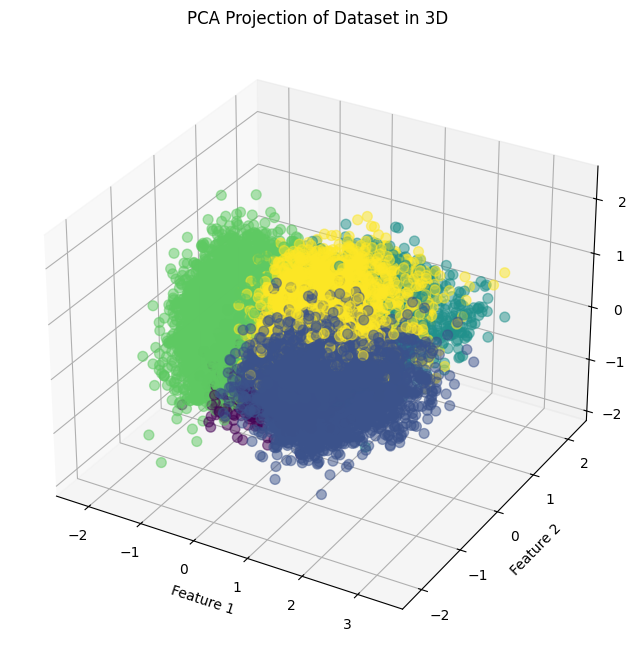

<Figure size 640x480 with 0 Axes>

In [13]:
# KMeans 클러스터링 결과를 시각화
plt.figure(figsize=(8, 6))

# 3차원 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['component 0'], df_pca['component 1'], df_pca['component 2'], c=kmeans_labels, cmap='viridis', s=50, alpha=0.5)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('PCA Projection of Dataset in 3D')
plt.show()
plt.savefig(f"./{num_clusters}_PCA_3d")

# 데이터에 라벨 추가

In [14]:
### info 데이터에 군집화 라벨 추가
df['cluster'] = kmeans_labels
df['cluster'].value_counts()

cluster
3    15539
0    14566
2     8862
4     8080
1     6982
Name: count, dtype: int64

In [15]:
# 군집화 라벨이 추가된 informative 문장 저장
df.to_csv(f'./비금융_Kmeans_pvdm100_#{num_clusters}.csv', encoding='utf-8-sig')

In [45]:
# # 각 군집에서의 문장을 sample해서 봐보기 위한 코드입니다
# cluster_index = np.unique(kmeans_labels)

# representative_sentence = {}

# for i in cluster_index:
#     sent_sample = df['review'][df['cluster']==i].sample(n=3, random_state=26)
#     representative_sentence[str(i)+'번 군집'] = sent_sample.iloc[:]

In [46]:
# for i in representative_sentence.keys():
#     print(i)
#     for n in range(len(representative_sentence[i])):
#         print(representative_sentence[i].iloc[n])
#     print()